In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("gdrive/My Drive/HW4/Mask_RCNN/samples/shapes") 

In [3]:
!ls

0856065_10.json  0856065_2.json  0856065_9.json
0856065_11.json  0856065_3.json  ngrok
0856065_12.json  0856065_4.json  ngrok-stable-linux-amd64.zip
0856065_13.json  0856065_5.json  ngrok-stable-linux-amd64.zip.1
0856065_14.json  0856065_6.json  shapes.py
0856065_15.json  0856065_7.json  train_shapes.ipynb
0856065_1.json	 0856065_8.json  utils.py


In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [5]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 20  # background + 20 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    STEPS_PER_EPOCH = 800

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                33
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import glob

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [8]:
coco = COCO("../../../pascal_train.json") # load training annotations

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!


In [0]:
img_list = list(coco.imgs.keys())

In [0]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, st, ed, img_floder):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "aeroplane")
        self.add_class("shapes", 2, "bicycle")
        self.add_class("shapes", 3, "bird")
        self.add_class("shapes", 4, "boat")
        self.add_class("shapes", 5, "bottle")
        self.add_class("shapes", 6, "bus")
        self.add_class("shapes", 7, "car")
        self.add_class("shapes", 8, "cat")
        self.add_class("shapes", 9, "chair")
        self.add_class("shapes", 10, "cow")
        self.add_class("shapes", 11, "diningtable")
        self.add_class("shapes", 12, "dog")
        self.add_class("shapes", 13, "horse")
        self.add_class("shapes", 14, "motorbike")
        self.add_class("shapes", 15, "person")
        self.add_class("shapes", 16, "pottedplant")
        self.add_class("shapes", 17, "sheep")
        self.add_class("shapes", 18, "sofa")
        self.add_class("shapes", 19, "train")
        self.add_class("shapes", 20, "tvmonitor")

        # Add images
        for i in range(st, ed):
            imgIds = img_list[i] # Use the key above to retrieve information of the image
            img_info = coco.loadImgs(ids=imgIds)
            self.add_image("shapes", image_id=imgIds, path="{}{}".format(img_floder, img_info[0]['file_name']),
                           width=img_info[0]['width'], height=img_info[0]['height'])

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        imgIds = info['id'] # Use the key above to retrieve information of the image
        annids = coco.getAnnIds(imgIds=imgIds)
        anns = coco.loadAnns(annids)
        count = len(annids)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i in range(count):
          submask = coco.annToMask(anns[i])
          submask = submask.reshape(info['height'], info['width'], 1)
          mask[:, :, i:i+1] = submask
        
        # Map class names to class IDs.
        class_ids = np.array([anns[s]['category_id'] for s in range(len(annids))])
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [0]:
img_folder = "../../../train_images/"
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(135, 1214, img_folder)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(0, 135, img_folder)
dataset_val.prepare()

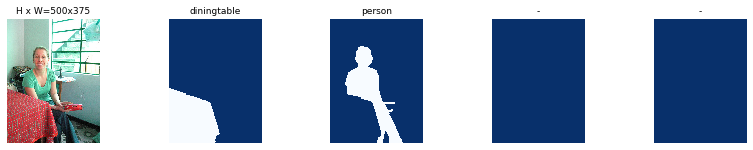

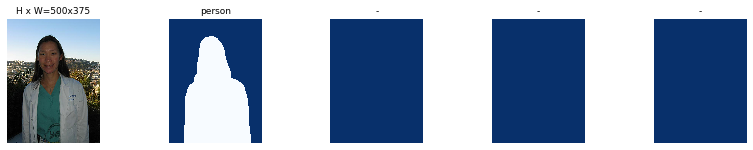

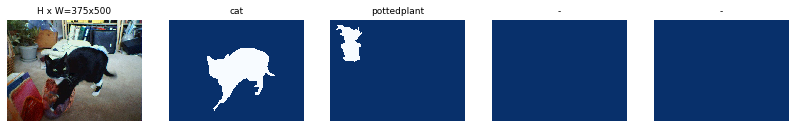

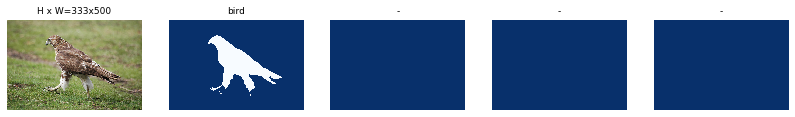

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [37]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 50


In [15]:
model.load_weights("../../logs/shapes20191218T1531/mask_rcnn_shapes_0050.h5", by_name=True)







Re-starting from epoch 50


In [19]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 20. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/HW4/Mask_RCNN/logs/shapes20191218T1531/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 21/30
800/800 [==============================] - 169s 212ms/step - loss: 1.2035 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.2866 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.2771 - mrcnn_mask_loss: 0.4055 - val_loss: 2.5559 - val_rpn_class_loss: 0.0538 - val_rpn_bbox_loss: 1.0311 - val_mrcnn_class_loss: 0.4941 - val_mrcnn_bbox_loss: 0.4892 - val_mrcnn_mask_loss: 0.4877
Epoch 22/30
800/800 [==============================] - 144s 180ms/step - loss: 1.0493 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.2391 - mrcnn_mask_loss: 0.3913 - val_loss: 1.7188 - val_rpn_class_loss: 0.0342 - val_rpn_bbox_loss: 0.5058 - val_mrcnn_class_loss: 0.3227 - val_mrcnn_bbox_loss: 0.3957 - val_mrcnn_mask_loss: 0.4604
Epoch 23/30
800/800 [==============================] - 145s 181ms/step - loss: 1.0567 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.2330 - mrcnn_mask_loss: 0.3882 - val_loss: 1.8612 - val

In [0]:
# Data augmentation
import imgaug as ia
import imgaug.augmenters as iaa
seq = iaa.Sometimes(0.833, iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.2), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-45, 45), # rotate by -45 to +45 degrees
        shear=(-16, 16), # shear by -16 to +16 degrees
        order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
    )
], random_order=True)) # apply augmenters in random order

In [19]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=90, 
            layers="all",
            augmentation=seq)


Starting at epoch 70. LR=0.0001

Checkpoint Path: /content/gdrive/My Drive/HW4/Mask_RCNN/logs/shapes20191218T1531/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 71/90
800/800 [==============================] - 302s 377ms/step - loss: 2.1696 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.8801 - mrcnn_class_loss: 0.4094 - mrcnn_bbox_loss: 0.3928 - mrcnn_mask_loss: 0.3980 - val_loss: 1.1723 - val_rpn_class_loss: 0.0110 - val_rpn_bbox_loss: 0.1899 - val_mrcnn_class_loss: 0.3907 - val_mrcnn_bbox_loss: 0.3337 - val_mrcnn_mask_loss: 0.2469
Epoch 72/90
800/800 [==============================] - 252s 315ms/step - loss: 2.0612 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.7772 - mrcnn_class_loss: 0.4345 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.3852 - val_loss: 1.1939 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.3260 - val_mrcnn_class_loss: 0.2261 - val_mrcnn_bbox_loss: 0.4032 - val_mrcnn_mask_loss: 0.2286
Epoch 73/90
800/800 [==============================] - 256s 320ms/step - loss: 1.9592 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.7580 - mrcnn_class_loss: 0.3852 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.3868 - val_loss: 2.2185 - val

In [0]:
img_folder = "../../../train_images/"
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(0, 1214, img_folder)
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(1214, 1349, img_folder)
dataset_val.prepare()

In [0]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=110, 
            layers="all",
            augmentation=seq)


Starting at epoch 90. LR=0.0001

Checkpoint Path: /content/gdrive/My Drive/HW4/Mask_RCNN/logs/shapes20191218T1531/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 91/110
800/800 [==============================] - 318s 397ms/step - loss: 1.9770 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.7325 - mrcnn_class_loss: 0.4104 - mrcnn_bbox_loss: 0.3944 - mrcnn_mask_loss: 0.3791 - val_loss: 1.5310 - val_rpn_class_loss: 0.0242 - val_rpn_bbox_loss: 0.2004 - val_mrcnn_class_loss: 0.5242 - val_mrcnn_bbox_loss: 0.3654 - val_mrcnn_mask_loss: 0.4169
Epoch 92/110
800/800 [==============================] - 263s 329ms/step - loss: 2.0194 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 0.7884 - mrcnn_class_loss: 0.4051 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.3678 - val_loss: 1.2825 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.4495 - val_mrcnn_class_loss: 0.1956 - val_mrcnn_bbox_loss: 0.3372 - val_mrcnn_mask_loss: 0.2895
Epoch 93/110
800/800 [==============================] - 258s 323ms/step - loss: 1.8497 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.7101 - mrcnn_class_loss: 0.3710 - mrcnn_bbox_loss: 0.3596 - mrcnn_mask_loss: 0.3539 - val_loss: 2.0987 - 

In [61]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = "../../logs/shapes20191218T1531/mask_rcnn_shapes_0250.h5"
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../../logs/shapes20191218T1531/mask_rcnn_shapes_0250.h5
Re-starting from epoch 250


Processing 1 images
image                    shape: (500, 375, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 33)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


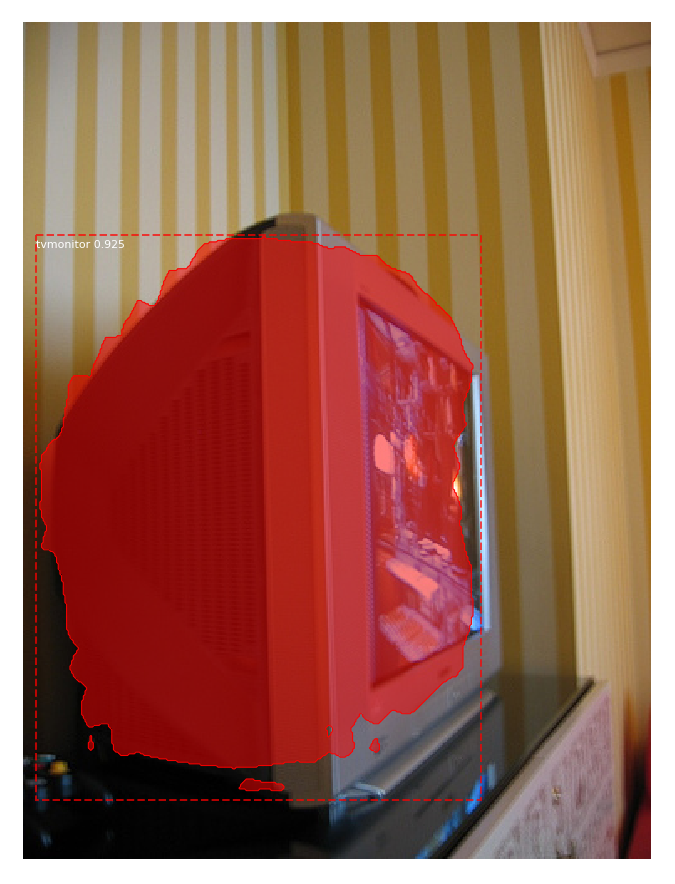

In [67]:
import skimage.io

IMAGE_DIR = "../../../test_images/"
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

In [53]:
cocoGt = COCO("../../../test.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [0]:
import numpy as np
from itertools import groupby
from pycocotools import mask as maskutil

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

In [68]:
coco_dt = []
file_names = next(os.walk(IMAGE_DIR))[2]
for imgid in cocoGt.imgs:
  image = cv2.imread(IMAGE_DIR + cocoGt.loadImgs(ids=imgid)[0]['file_name'])[:,:,::-1]

  # Run detection
  results = model.detect([image], verbose=1)
  r = results[0]
  n_instances = len(r['scores'])
  if n_instances > 0:
    for i in range(n_instances):
      # save information of the instance in a dictionary then append on coco_dt list
          pred = {}
          pred['image_id'] = imgid # this imgid must be same as the key of test.json
          pred['category_id'] = int(r['class_ids'][i])
          pred['segmentation'] = binary_mask_to_rle(r['masks'][:,:,i]) # save binary mask to RLE, e.g. 512x512 -> rle
          pred['score'] = float(r['scores'][i])
          coco_dt.append(pred)
  # Visualize results
  #r = results[0]
  #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
  #                            dataset_val.class_names, r['scores'])

Processing 1 images
image                    shape: (333, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 33)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 33)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Processing 1 images
image                    shape: (262, 350, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.1

In [0]:
with open("0856065_17.json", "w") as f:
    json.dump(coco_dt, f)